In [1]:
import tensorflow as tf

print(tf.__version__)

2.10.0


In [2]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array  # Import necessary functions

def load_images_from_directory(directory, label, target_size):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(directory, filename)
            img = load_img(img_path, target_size=target_size)
            img = img_to_array(img)
            images.append(np.array(img))
            labels.append(label)
    return images, labels

X_train = []
y_train = []
X_test = []
y_test = []

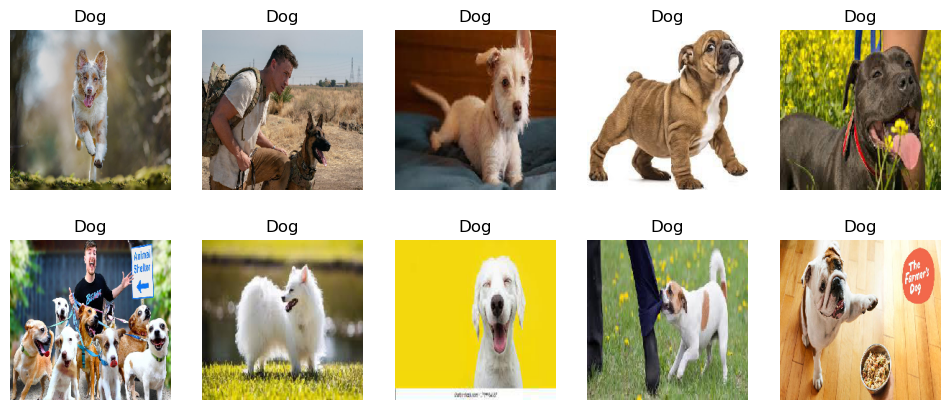

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Load images from the extracted directory
train_dog_imgs, train_dog_labels = load_images_from_directory(r'archive\train\dogs', label = 0, target_size = (224, 224, 3))
test_dog_imgs, test_dog_labels = load_images_from_directory(r'archive\test\dogs', label = 0, target_size = (224, 224, 3))

X_train += train_dog_imgs
X_test += test_dog_imgs
y_train += train_dog_labels
y_test += test_dog_labels

_, axs = plt.subplots(2, 5, figsize = (12, 5))

axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.imshow(train_dog_imgs[i].astype('uint8'))
    ax.set_title('Dog')
    ax.axis('off')

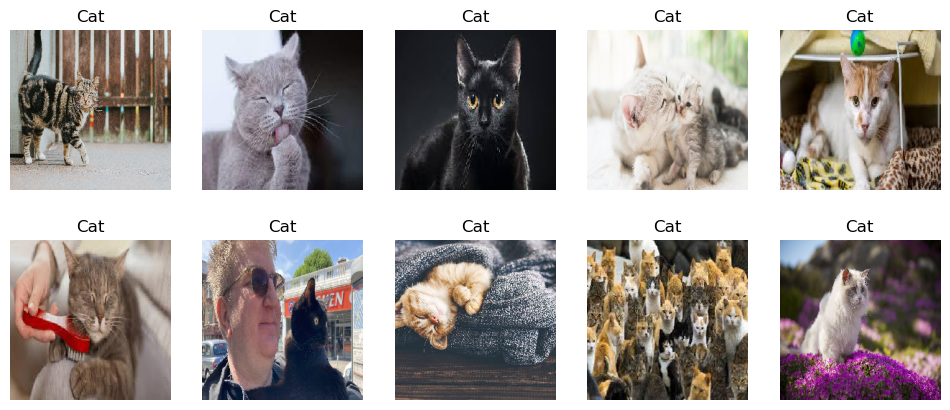

In [5]:
train_cat_imgs, train_cat_labels = load_images_from_directory(r'archive\train\cats', 1, target_size = (224, 224, 3))
test_cat_imgs, test_cat_labels = load_images_from_directory(r'archive\test\cats', 1, target_size = (224, 224, 3))

X_train += train_cat_imgs
X_test += test_cat_imgs
y_train += train_cat_labels
y_test += test_cat_labels

_, axs = plt.subplots(2, 5, figsize = (12, 5))

axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.imshow(train_cat_imgs[i].astype('uint8'))
    ax.set_title('Cat')
    ax.axis('off')

In [6]:
X_train = (np.array(X_train)/255.0).astype('float32')
X_test = (np.array(X_test)/255.0).astype('float32')

In [7]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=90,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip = True)

test_datagen  = ImageDataGenerator(rotation_range=90,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip = True)

# Flowing training images using train_datagen generator
train_generator = train_datagen.flow(x = X_train, y = y_train, batch_size = np.array(X_train).shape[0], seed = 42, shuffle = True)

# Flowing validation images using val_datagen generator
test_generator =  test_datagen.flow(x = X_test, y = y_test, batch_size = np.array(X_test).shape[0], seed = 42, shuffle = True)

X_train, y_train = next(train_generator)
X_test, y_test = next(test_generator)

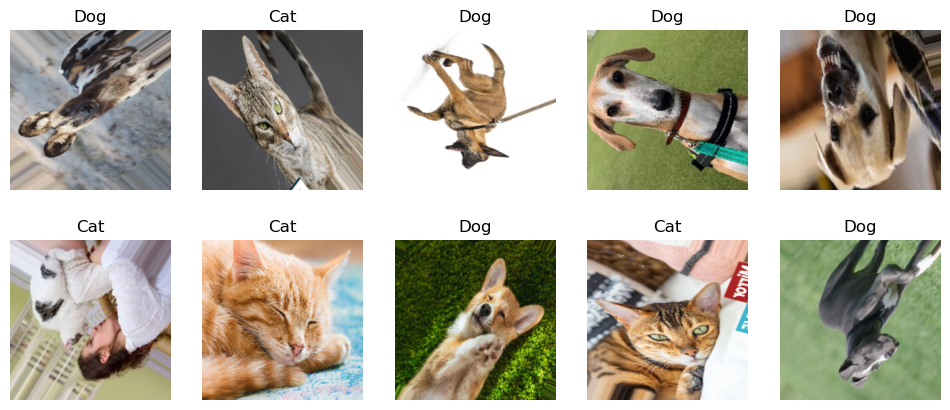

In [8]:
_, axs = plt.subplots(2, 5, figsize = (12, 5))

axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.imshow(X_train[i])
    if y_train[i] == 1: 
        ax.set_title('Cat')
    else:
        ax.set_title('Dog')
    ax.axis('off')

In [9]:
print('Number of Record', X_train.shape[0])

Number of Record 557


In [10]:
# Since the data set is small, its better to use a pretrained model, especially a model trained on imagenet dataset.

from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights = 'imagenet',
                       include_top = True, # since immagenet dataset has cats and dog categories we will import the top layers
                       input_shape = (224, 224, 3), pooling = 'max')

In [11]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
vgg_model.trainable = False

In [13]:
x = (vgg_model.output)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.1)(x)
x = Dense(512, activation = 'relu')(x)
pred = Dense(1, activation = 'sigmoid')(x)

# Initializing the model
model = Model(vgg_model.input, pred)

In [14]:
model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
early_stopping= EarlyStopping(monitor = 'val_loss', patience = 10)
checkpoint = ModelCheckpoint('best_model.h5',  monitor='val_loss', save_best_only=True, mode='min', verbose=1 )

In [17]:
history = model.fit(
            X_train, y_train,
            epochs = 100,
            batch_size = 4,
            validation_split=0.1,
            verbose = 1,
            callbacks = [early_stopping, checkpoint]
)

Epoch 1/100
126/126 [==============================] - ETA: 0s - loss: 0.6938 - accuracy: 0.4631
Epoch 1: val_loss improved from inf to 0.69323, saving model to best_model.h5
126/126 [==============================] - 8s 36ms/step - loss: 0.6938 - accuracy: 0.4631 - val_loss: 0.6932 - val_accuracy: 0.5357
Epoch 2/100
124/126 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5020
Epoch 2: val_loss did not improve from 0.69323
126/126 [==============================] - 3s 23ms/step - loss: 0.6928 - accuracy: 0.5050 - val_loss: 0.6938 - val_accuracy: 0.4464
Epoch 3/100
126/126 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.4810
Epoch 3: val_loss did not improve from 0.69323
126/126 [==============================] - 3s 24ms/step - loss: 0.6929 - accuracy: 0.4810 - val_loss: 0.6938 - val_accuracy: 0.4643
Epoch 4/100
124/126 [============================>.] - ETA: 0s - loss: 0.6917 - accuracy: 0.5101
Epoch 4: val_loss did not improve from 0.693

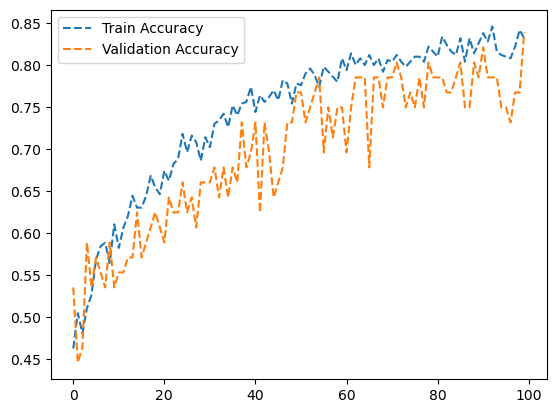

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], ls = '--', label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], ls = '--', label = 'Validation Accuracy')
plt.legend()
plt.show()

5/5 [==============================] - 6s 565ms/step
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        70
           1       0.76      0.76      0.76        70

    accuracy                           0.76       140
   macro avg       0.76      0.76      0.76       140
weighted avg       0.76      0.76      0.76       140



Text(0.5, 25.722222222222214, 'Predicted')

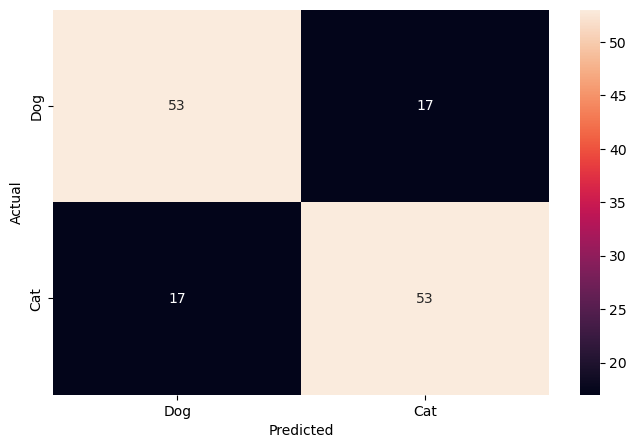

In [19]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Making predictions on the test data
y_pred = model.predict(X_test)

# Converting probabilities to class labels
y_pred = (y_pred >= 0.5).astype(int)

# Printing the classification report
print(classification_report(y_test, y_pred))  # Use class labels for both

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_test, y_pred)  # Use class labels for both

plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='.0f', xticklabels=['Dog', 'Cat'], yticklabels=['Dog','Cat'])
plt.ylabel('Actual')
plt.xlabel('Predicted')


In [20]:
from tensorflow import keras 
keras.backend.clear_session() 